## Import Packages

In [1]:
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn import cluster, metrics, datasets
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from pylab import rcParams
rcParams['figure.figsize'] = 12,10

# Pandas set options to show 2 decimal spots, commas
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
os.chdir('../')

# Import helper functions
from lib.cluster import kmeans, find_best_cluster, feature_importance, plot_kmeans_cluster

## Import Data

#### Main Dataframe

In [3]:
df = pd.read_excel('data/fi-analytics-data.xlsx', sheet_name='Data')
data = df
print(df.shape)
df.head()

(4753, 131)


,DWCGPortfolioID,AsofDate,InvestmentPortfolioTypeCode,ProcessCycleDate,PortfolioUID,TotalUSDMarketValue,FICustomUSDMarketValue,PrimaryPrice,InstrumentCouponRate,CurrentSpreadBasisPoint,...,FundAccountSubTypeName,PortfolioName,InvestmentPortfolioTypeCode.1,InvestmentAssetClassName,InvestmentAccountUID,InvestmentPortfolioName,Investment Spectrum,Performance Grouping,InvestmentPortfolioBaseTypeName,PortfolioCategoryTypeName
0,1967582,2019-01-31,AA,2019-01-31,404305,0.00,0.00,0.00,0.00,0.00,...,NaN,AECOM3968 44396800,AA,Fixed Income,7100494,NaN,NaN,NaN,Investment Entity,CG Investment Portfolio
1,1967904,2019-03-29,AA,2019-03-29,404305,"13,330,424.88","13,330,424.88",104.35,4.36,0.00,...,NaN,AECOM3968 44396800,AA,Fixed Income,7100494,NaN,NaN,NaN,Investment Entity,CG Investment Portfolio
2,1967904,2019-02-28,AA,2019-02-28,404305,"12,743,550.83","12,743,550.83",100.26,4.31,0.00,...,NaN,AECOM3968 44396800,AA,Fixed Income,7100494,NaN,NaN,NaN,Investment Entity,CG Investment Portfolio
3,1967904,2019-04-30,AA,2019-04-30,404305,"13,414,264.03","13,414,264.03",105.00,4.28,0.00,...,NaN,AECOM3968 44396800,AA,Fixed Income,7100494,NaN,NaN,NaN,Investment Entity,CG Investment Portfolio
4,1967904,2019-05-31,AA,2019-05-31,404305,"13,704,476.48","13,704,476.48",109.38,4.37,0.00,...,NaN,AECOM3968 44396800,AA,Fixed Income,7100494,NaN,NaN,NaN,Investment Entity,CG Investment Portfolio


### Column Headers

In [4]:
headers = df.columns.values

#### Filter columns into sets for later use

In [5]:
#Filter out the DW.+ columns from the main dataframe
regex = re.compile(r'EffectiveKeyRateDuration.+|YieldToWorst.+|YieldtoMaturity.+|OptionAdjustedSpread.+|AverageLife.+|Coupon.+')

key_cols = sorted(list(filter(regex.search, headers)))
key_cols

['AlternativeOptionAdjustedSpreadBasisPoint',
 'EffectiveKeyRateDuration10YearNumber',
 'EffectiveKeyRateDuration15YearNumber',
 'EffectiveKeyRateDuration1YearNumber',
 'EffectiveKeyRateDuration20YearNumber',
 'EffectiveKeyRateDuration25YearNumber',
 'EffectiveKeyRateDuration2YearNumber',
 'EffectiveKeyRateDuration30YearNumber',
 'EffectiveKeyRateDuration3MonthNumber',
 'EffectiveKeyRateDuration3YearNumber',
 'EffectiveKeyRateDuration40YearNumber',
 'EffectiveKeyRateDuration50YearNumber',
 'EffectiveKeyRateDuration5YearNumber',
 'EffectiveKeyRateDuration7YearNumber',
 'InstrumentCouponRate',
 'OptionAdjustedSpreadBasisPoint',
 'ProjectedWeightedAverageCouponNumber',
 'ProjectedWeightedAverageLifeEquivalentCPRNumber',
 'ProjectedWeightedAverageLifeEquivalentPSANumber',
 'WeightedAverageLifeNumber',
 'WeightedAverageLifetoMaturityNumber',
 'WeightedAverageLifetoWorstNumber',
 'YieldToWorstSpreadToMaturityNumber',
 'YieldToWorstWithSinkingFundPercent',
 'YieldtoMaturityPercent',
 'ZeroVol

In [6]:
feat_cols = key_cols
feat_cols

['AlternativeOptionAdjustedSpreadBasisPoint',
 'EffectiveKeyRateDuration10YearNumber',
 'EffectiveKeyRateDuration15YearNumber',
 'EffectiveKeyRateDuration1YearNumber',
 'EffectiveKeyRateDuration20YearNumber',
 'EffectiveKeyRateDuration25YearNumber',
 'EffectiveKeyRateDuration2YearNumber',
 'EffectiveKeyRateDuration30YearNumber',
 'EffectiveKeyRateDuration3MonthNumber',
 'EffectiveKeyRateDuration3YearNumber',
 'EffectiveKeyRateDuration40YearNumber',
 'EffectiveKeyRateDuration50YearNumber',
 'EffectiveKeyRateDuration5YearNumber',
 'EffectiveKeyRateDuration7YearNumber',
 'InstrumentCouponRate',
 'OptionAdjustedSpreadBasisPoint',
 'ProjectedWeightedAverageCouponNumber',
 'ProjectedWeightedAverageLifeEquivalentCPRNumber',
 'ProjectedWeightedAverageLifeEquivalentPSANumber',
 'WeightedAverageLifeNumber',
 'WeightedAverageLifetoMaturityNumber',
 'WeightedAverageLifetoWorstNumber',
 'YieldToWorstSpreadToMaturityNumber',
 'YieldToWorstWithSinkingFundPercent',
 'YieldtoMaturityPercent',
 'ZeroVol

In [7]:
feat_cols.insert(0, 'FICustomUSDMarketValue')

In [8]:
key_cols

['FICustomUSDMarketValue',
 'AlternativeOptionAdjustedSpreadBasisPoint',
 'EffectiveKeyRateDuration10YearNumber',
 'EffectiveKeyRateDuration15YearNumber',
 'EffectiveKeyRateDuration1YearNumber',
 'EffectiveKeyRateDuration20YearNumber',
 'EffectiveKeyRateDuration25YearNumber',
 'EffectiveKeyRateDuration2YearNumber',
 'EffectiveKeyRateDuration30YearNumber',
 'EffectiveKeyRateDuration3MonthNumber',
 'EffectiveKeyRateDuration3YearNumber',
 'EffectiveKeyRateDuration40YearNumber',
 'EffectiveKeyRateDuration50YearNumber',
 'EffectiveKeyRateDuration5YearNumber',
 'EffectiveKeyRateDuration7YearNumber',
 'InstrumentCouponRate',
 'OptionAdjustedSpreadBasisPoint',
 'ProjectedWeightedAverageCouponNumber',
 'ProjectedWeightedAverageLifeEquivalentCPRNumber',
 'ProjectedWeightedAverageLifeEquivalentPSANumber',
 'WeightedAverageLifeNumber',
 'WeightedAverageLifetoMaturityNumber',
 'WeightedAverageLifetoWorstNumber',
 'YieldToWorstSpreadToMaturityNumber',
 'YieldToWorstWithSinkingFundPercent',
 'Yieldto

### Priority Columns

Top Metrics to consider:

- Effective Duration
- Yield to Worst
- Yield to Maturity
- OAS
- Average Life
- Coupon

In [9]:
ref_cols = ['AsofDate', 'InvestmentPortfolioName', 'PortfolioName', 'PortfolioUID', 
            'InvestmentAccountUID','FundAccountTypeName', 'FundAccountSubTypeName',
            'Investment Spectrum','Performance Grouping'] 

ref_cols

['AsofDate',
 'InvestmentPortfolioName',
 'PortfolioName',
 'PortfolioUID',
 'InvestmentAccountUID',
 'FundAccountTypeName',
 'FundAccountSubTypeName',
 'Investment Spectrum',
 'Performance Grouping']

## Exploratory Data Analysis

In [10]:
df.describe()

,DWCGPortfolioID,PortfolioUID,TotalUSDMarketValue,FICustomUSDMarketValue,PrimaryPrice,InstrumentCouponRate,CurrentSpreadBasisPoint,DiscountMarginBasisPoint,MacauleyDurationNumber,ModifiedDurationtoMaturityNumber,...,ProjectedWeightedAverageMaturityNumber,ProjectedWeightedAverageCouponNumber,CGDollarValue01Percent,TraderDurationNumber,YieldToWorstWithSinkingFundPercent,YieldToCallPercent,DWCreateByProcessID,DWUpdateByProcessID,DWVersion,InvestmentAccountUID
count,"4,753.00","4,753.00","4,753.00","4,753.00","4,753.00","4,753.00","4,753.00","4,753.00","4,753.00","4,753.00",...,"4,753.00","4,753.00","4,753.00","4,753.00","4,753.00","4,753.00","4,753.00","4,753.00","4,753.00","4,753.00"
mean,"1,683,076.94","208,279.92","6,466,020,810.41","1,369,329,153.17",170.01,2.74,-0.12,3.38,4.41,4.41,...,5.70,0.20,0.05,3.41,0.00,0.42,530.94,530.94,0.00,"91,505,874.32"
std,"252,547.98","121,121.97","22,793,699,765.38","5,932,134,284.74",784.71,3.32,0.78,16.52,4.84,4.84,...,9.60,0.40,0.05,2.73,0.00,31.34,1.00,1.00,0.00,"68,889,114.32"
min,"1,194,666.00",1.00,"-637,862.61","-637,862.61","-14,905.88",-55.31,-21.36,-334.50,-6.08,-6.05,...,-119.00,-0.00,-0.01,-1.50,0.00,"-1,041.58",530.00,530.00,0.00,"100,063.00"
25%,"1,552,070.00","105,823.00","5,851,330.66","256,793.41",0.00,0.00,0.00,0.00,1.38,1.37,...,0.00,0.00,0.01,1.01,0.00,0.00,530.00,530.00,0.00,"28,064,476.00"
50%,"1,768,385.00","229,829.00","81,019,129.14","22,252,551.22",101.87,2.85,0.00,0.16,4.58,4.58,...,6.00,0.00,0.05,3.36,0.00,0.01,530.00,530.00,0.00,"74,100,137.00"
75%,"1,885,303.00","302,953.00","849,089,467.35","284,265,297.55",136.29,4.30,0.00,2.00,6.20,6.21,...,9.00,0.24,0.07,5.19,0.00,0.02,532.00,532.00,0.00,"162,100,013.00"
max,"2,070,705.00","413,372.00","199,318,080,594.02","113,375,155,864.01","30,951.34",117.05,0.12,525.38,245.79,245.62,...,300.00,6.07,0.92,31.39,0.00,"1,382.34",532.00,532.00,0.00,"211,101,547.00"


#### Correlation Matrix

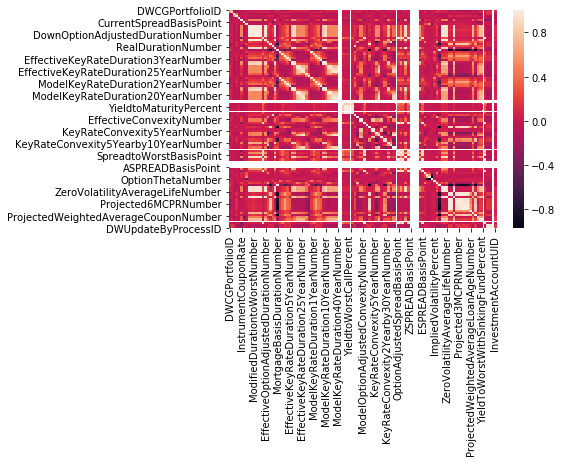

In [11]:
sns.heatmap(df.corr())

In [12]:
#df.info(verbose=True, null_counts=True)

## Preprocessing Data

#### Filter for Fixed Income, As of Date, and not PCS Funds

In [13]:
# Filter for As of Date, will be using "2019-06-28"
sorted(list(df.AsofDate.unique()))

[numpy.datetime64('1900-01-01T00:00:00.000000000'),
 numpy.datetime64('2018-05-31T00:00:00.000000000'),
 numpy.datetime64('2018-06-29T00:00:00.000000000'),
 numpy.datetime64('2018-07-31T00:00:00.000000000'),
 numpy.datetime64('2018-08-31T00:00:00.000000000'),
 numpy.datetime64('2018-09-28T00:00:00.000000000'),
 numpy.datetime64('2018-10-31T00:00:00.000000000'),
 numpy.datetime64('2018-11-30T00:00:00.000000000'),
 numpy.datetime64('2018-12-31T00:00:00.000000000'),
 numpy.datetime64('2019-01-31T00:00:00.000000000'),
 numpy.datetime64('2019-02-28T00:00:00.000000000'),
 numpy.datetime64('2019-03-29T00:00:00.000000000'),
 numpy.datetime64('2019-04-30T00:00:00.000000000'),
 numpy.datetime64('2019-05-31T00:00:00.000000000'),
 numpy.datetime64('2019-06-28T00:00:00.000000000')]

In [14]:
# Filter for Fixed Income
filter_fi = (df['InvestmentAssetClassName'] == 'Fixed Income')

# Filter for not PCS Funds
filter_pcs = (df['FundAccountSubTypeName'] != 'PCS Fund')

# Filter for recent As of Date
filter_date = (df['AsofDate'] == '2019-06-28') #2019-06-28

# All filters
filter_all = (filter_fi & filter_pcs & filter_date) #filter_date
#filter_all

In [15]:
df = df[filter_all]
print(df.shape)
df.head()

(109, 131)


,DWCGPortfolioID,AsofDate,InvestmentPortfolioTypeCode,ProcessCycleDate,PortfolioUID,TotalUSDMarketValue,FICustomUSDMarketValue,PrimaryPrice,InstrumentCouponRate,CurrentSpreadBasisPoint,...,FundAccountSubTypeName,PortfolioName,InvestmentPortfolioTypeCode.1,InvestmentAssetClassName,InvestmentAccountUID,InvestmentPortfolioName,Investment Spectrum,Performance Grouping,InvestmentPortfolioBaseTypeName,PortfolioCategoryTypeName
5,1967904,2019-06-28,AA,2019-06-28,404305,"14,259,104.70","14,259,104.70",112.67,4.41,0.00,...,NaN,AECOM3968 44396800,AA,Fixed Income,7100494,NaN,NaN,NaN,Investment Entity,CG Investment Portfolio
45,1291779,2019-06-28,AA,2019-06-28,231964,"6,339,839,622.69","6,339,839,622.69",174.86,3.18,0.00,...,American Fund,AFMF 11000042,AA,Fixed Income,197100048,American Funds Mortgage Fund,Taxable Bond,Mortgage Fund,Investment Entity,CG Investment Portfolio
348,1274095,2019-06-28,AA,2019-06-28,191422,"7,575,699,721.51","7,575,699,721.51",114.95,4.76,0.00,...,American Fund,AHIM 11000040,AA,Fixed Income,70001130,American High-Income Municipal Bond Fund,Tax-Exempt Bond,NaN,Investment Entity,CG Investment Portfolio
364,1198634,2019-06-28,AA,2019-06-28,11193,"16,612,608,727.96","16,612,608,727.96",96.28,6.36,0.00,...,American Fund,AHIT 11000021,AA,Fixed Income,21000021,American High-Income Trust,Taxable Bond,High-Income Bond/Trust Fund,Investment Entity,CG Investment Portfolio
412,1733587,2019-06-28,AA,2019-06-28,183673,"431,867,803.80","431,867,803.80",96.93,6.12,0.00,...,NaN,ALASKA3705 44370500,AA,Fixed Income,23101359,Alaska Permanent Fund US FI High Yield,NaN,NaN,Investment Entity,CG Investment Portfolio


#### Save a copy of the reference columns

In [16]:
ref_df = df[ref_cols]
ref_df.head()

,AsofDate,InvestmentPortfolioName,PortfolioName,PortfolioUID,InvestmentAccountUID,FundAccountTypeName,FundAccountSubTypeName,Investment Spectrum,Performance Grouping
5,2019-06-28,NaN,AECOM3968 44396800,404305,7100494,NaN,NaN,NaN,NaN
45,2019-06-28,American Funds Mortgage Fund,AFMF 11000042,231964,197100048,Mutual Fund,American Fund,Taxable Bond,Mortgage Fund
348,2019-06-28,American High-Income Municipal Bond Fund,AHIM 11000040,191422,70001130,Mutual Fund,American Fund,Tax-Exempt Bond,NaN
364,2019-06-28,American High-Income Trust,AHIT 11000021,11193,21000021,Mutual Fund,American Fund,Taxable Bond,High-Income Bond/Trust Fund
412,2019-06-28,Alaska Permanent Fund US FI High Yield,ALASKA3705 44370500,183673,23101359,NaN,NaN,NaN,NaN


In [17]:
ref_df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109 entries, 5 to 4752
Data columns (total 9 columns):
AsofDate                   109 non-null datetime64[ns]
InvestmentPortfolioName    98 non-null object
PortfolioName              109 non-null object
PortfolioUID               109 non-null int64
InvestmentAccountUID       109 non-null int64
FundAccountTypeName        50 non-null object
FundAccountSubTypeName     36 non-null object
Investment Spectrum        22 non-null object
Performance Grouping       10 non-null object
dtypes: datetime64[ns](1), int64(2), object(6)
memory usage: 8.5+ KB


#### Remove unneccessary columns

In [18]:
# Filter out the DW.+ columns from the main dataframe
regex = re.compile(r'DW.+')

del_cols = list(filter(regex.search, headers))

In [19]:
# Remove these columns from the main dataframe
del_cols.extend(['AsofDate', 'ProcessCycleDate', 'SourceSystem', 
                 'InvestmentPortfolioBaseTypeName', 'PortfolioCategoryTypeName',
                 'InvestmentPortfolioTypeCode', 'InvestmentPortfolioTypeCode.1',
                 'PortfolioUID', 'FundAccountTypeCode', 
                 'InvestmentAssetClassName', 'InvestmentAccountUID']) #InvestmentPortfolioName

# Remove duplicates
del_cols = list(sorted(dict.fromkeys(del_cols)))
del_cols

['AsofDate',
 'DWCGPortfolioID',
 'DWCreateByName',
 'DWCreateByProcessID',
 'DWCreateDate',
 'DWSourceSystemCode',
 'DWUpdateByName',
 'DWUpdateByProcessID',
 'DWUpdateDate',
 'DWVersion',
 'FundAccountTypeCode',
 'InvestmentAccountUID',
 'InvestmentAssetClassName',
 'InvestmentPortfolioBaseTypeName',
 'InvestmentPortfolioTypeCode',
 'InvestmentPortfolioTypeCode.1',
 'PortfolioCategoryTypeName',
 'PortfolioUID',
 'ProcessCycleDate',
 'SourceSystem']

In [20]:
# Save a copy of the original dataset, named "data"
df = df.drop(del_cols, axis=1)
df.head()

,TotalUSDMarketValue,FICustomUSDMarketValue,PrimaryPrice,InstrumentCouponRate,CurrentSpreadBasisPoint,DiscountMarginBasisPoint,MacauleyDurationNumber,ModifiedDurationtoMaturityNumber,ModifiedDurationtoWorstNumber,UpOptionAdjustedDurationNumber,...,CGDollarValue01Percent,TraderDurationNumber,YieldToWorstWithSinkingFundPercent,YieldToCallPercent,FundAccountTypeName,FundAccountSubTypeName,PortfolioName,InvestmentPortfolioName,Investment Spectrum,Performance Grouping
5,"14,259,104.70","14,259,104.70",112.67,4.41,0.00,0.49,13.26,13.26,13.57,13.03,...,0.15,9.97,0,0.03,NaN,NaN,AECOM3968 44396800,NaN,NaN,NaN
45,"6,339,839,622.69","6,339,839,622.69",174.86,3.18,0.00,-7.41,3.77,3.78,4.82,3.06,...,0.03,2.75,0,0.00,Mutual Fund,American Fund,AFMF 11000042,American Funds Mortgage Fund,Taxable Bond,Mortgage Fund
348,"7,575,699,721.51","7,575,699,721.51",114.95,4.76,0.00,0.98,9.79,9.79,5.25,7.16,...,0.07,5.67,0,0.07,Mutual Fund,American Fund,AHIM 11000040,American High-Income Municipal Bond Fund,Tax-Exempt Bond,NaN
364,"16,612,608,727.96","16,612,608,727.96",96.28,6.36,0.00,44.65,3.58,3.59,2.71,2.68,...,0.03,0.80,0,0.34,Mutual Fund,American Fund,AHIT 11000021,American High-Income Trust,Taxable Bond,High-Income Bond/Trust Fund
412,"431,867,803.80","431,867,803.80",96.93,6.12,0.00,26.47,3.43,3.43,2.84,2.78,...,0.03,0.73,0,0.37,NaN,NaN,ALASKA3705 44370500,Alaska Permanent Fund US FI High Yield,NaN,NaN


In [21]:
df.shape

(109, 111)

In [22]:
#df.info(verbose=True, null_counts=True)

In [23]:
# Remove these last categorical columns because they have a bunch of nulls, which is skewing up the analysis
df.drop(['FundAccountTypeName', 'FundAccountSubTypeName', 'InvestmentPortfolioName', 'PortfolioName', 'Investment Spectrum', 'Performance Grouping'], axis=1, inplace=True)

In [24]:
df.shape

(109, 105)

In [25]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109 entries, 5 to 4752
Data columns (total 105 columns):
TotalUSDMarketValue                                109 non-null float64
FICustomUSDMarketValue                             109 non-null float64
PrimaryPrice                                       109 non-null float64
InstrumentCouponRate                               109 non-null float64
CurrentSpreadBasisPoint                            109 non-null float64
DiscountMarginBasisPoint                           109 non-null float64
MacauleyDurationNumber                             109 non-null float64
ModifiedDurationtoMaturityNumber                   109 non-null float64
ModifiedDurationtoWorstNumber                      109 non-null float64
UpOptionAdjustedDurationNumber                     109 non-null float64
DownOptionAdjustedDurationNumber                   109 non-null float64
ModelOptionAdjustedDurationNumber                  109 non-null float64
AlternativeOptionAdjustedSpre

In [26]:
df = df[key_cols]

## Data Preparation 

In [27]:
X = df #test_df #prep_df

In [28]:
# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#### Principal Component Analysis for Dimensionality Reduction

In [29]:
pca = PCA(n_components=2)
pca.fit(X_scaled)

X_pca = pca.transform(X_scaled)
print("Cumulative Explained Variance:", pca.explained_variance_ratio_.sum())

Cumulative Explained Variance: 0.5285969015772958


In [30]:
#pd.DataFrame(pca.components_, columns=df.columns.values, index = ['PC-1','PC-2']).T.sort_values('PC-1', ascending=False)

### KMeans Clustering

#### Using Helper Functions

Best Silhouette Score: 0.6320810813999176


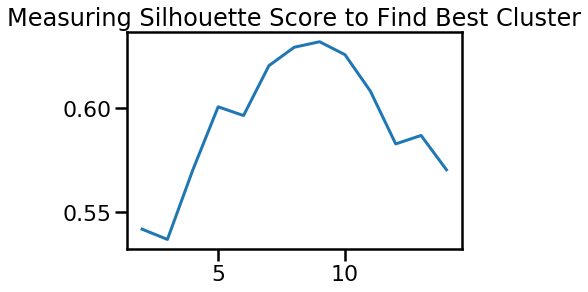

In [31]:
# Using the silhouette score, determine what the optimal number of clusters is
find_best_cluster(X_pca,15) #X_pca LDA_reduced_df

In [32]:
number_of_clusters = 9

In [33]:
cluster_output = kmeans(X_pca, number_of_clusters) #X_pca LDA_reduced_df
cluster_output

{'labels': array([0, 8, 1, 4, 4, 5, 5, 2, 4, 5, 1, 1, 5, 5, 3, 7, 2, 3, 5, 1, 1, 3,
        4, 4, 2, 3, 3, 2, 3, 4, 0, 1, 1, 1, 1, 5, 5, 4, 0, 4, 5, 3, 3, 3,
        0, 0, 1, 1, 8, 7, 8, 2, 5, 4, 0, 3, 0, 5, 7, 1, 4, 0, 4, 5, 0, 5,
        0, 0, 3, 7, 0, 6, 7, 7, 7, 7, 1, 1, 1, 7, 7, 7, 7, 0, 8, 7, 5, 1,
        1, 1, 3, 3, 5, 5, 0, 0, 0, 0, 7, 1, 8, 4, 8, 3, 5, 3, 1, 0, 0]),
 'centroids': array([[ 5.5692, -0.8259],
        [ 0.586 , -0.4386],
        [-2.9011,  0.8696],
        [-2.814 , -3.1437],
        [-0.9561,  3.694 ],
        [ 0.8581,  1.5064],
        [-4.4047,  7.7381],
        [-2.1639, -0.6235],
        [-4.8723, -0.2792]]),
 'inertia': 53.174869068556355,
 'silhouette_score': 0.6320810813999176}

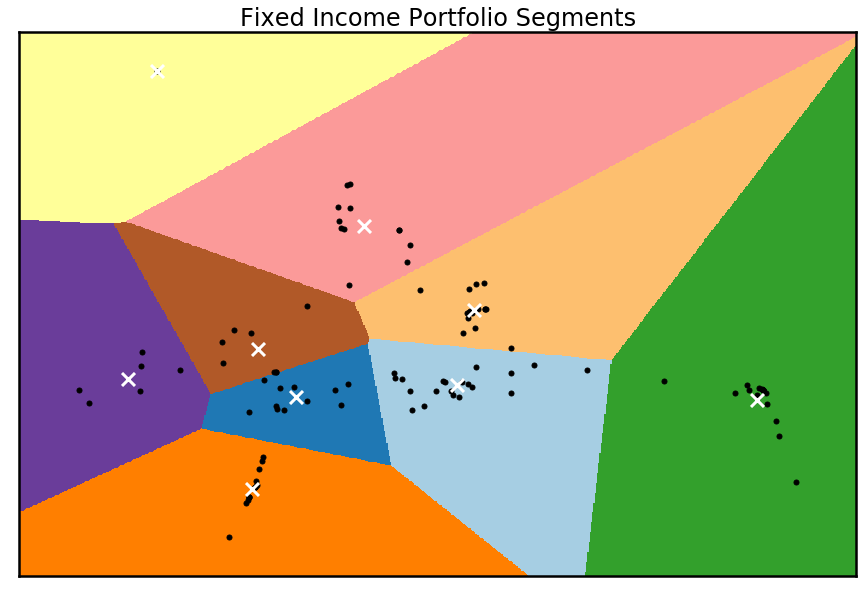

In [34]:
plot_kmeans_cluster(X_pca, number_of_clusters, 'Fixed Income Portfolio Segments')

### Cluster Investigation

In [35]:
# Identify the numbers of records in each cluster and any outliers
df['Groups'] = cluster_output['labels']
df['Groups'].value_counts()

1    20
0    19
5    17
3    15
7    14
4    12
8     6
2     5
6     1
Name: Groups, dtype: int64

In [36]:
# Bring in the reference columns for data visualization
df = pd.concat([df, ref_df], axis=1)
df.head()

,FICustomUSDMarketValue,AlternativeOptionAdjustedSpreadBasisPoint,EffectiveKeyRateDuration10YearNumber,EffectiveKeyRateDuration15YearNumber,EffectiveKeyRateDuration1YearNumber,EffectiveKeyRateDuration20YearNumber,EffectiveKeyRateDuration25YearNumber,EffectiveKeyRateDuration2YearNumber,EffectiveKeyRateDuration30YearNumber,EffectiveKeyRateDuration3MonthNumber,...,Groups,AsofDate,InvestmentPortfolioName,PortfolioName,PortfolioUID,InvestmentAccountUID,FundAccountTypeName,FundAccountSubTypeName,Investment Spectrum,Performance Grouping
5,"14,259,104.70",174.53,1.92,1.73,0.04,2.07,2.19,0.08,3.42,0.00,...,0,2019-06-28,NaN,AECOM3968 44396800,404305,7100494,NaN,NaN,NaN,NaN
45,"6,339,839,622.69",8.25,-0.34,0.14,0.25,0.15,-0.07,0.95,-0.12,0.15,...,8,2019-06-28,American Funds Mortgage Fund,AFMF 11000042,231964,197100048,Mutual Fund,American Fund,Taxable Bond,Mortgage Fund
348,"7,575,699,721.51",110.92,1.09,1.27,0.09,0.98,0.66,0.32,0.38,0.02,...,1,2019-06-28,American High-Income Municipal Bond Fund,AHIM 11000040,191422,70001130,Mutual Fund,American Fund,Tax-Exempt Bond,NaN
364,"16,612,608,727.96",438.31,0.15,0.02,0.13,0.02,0.03,0.24,0.00,0.05,...,4,2019-06-28,American High-Income Trust,AHIT 11000021,11193,21000021,Mutual Fund,American Fund,Taxable Bond,High-Income Bond/Trust Fund
412,"431,867,803.80",495.65,0.09,0.03,0.13,0.04,0.05,0.27,0.00,0.04,...,4,2019-06-28,Alaska Permanent Fund US FI High Yield,ALASKA3705 44370500,183673,23101359,NaN,NaN,NaN,NaN


In [37]:
data_dict = {key:g for key,g in df.groupby(['Groups'])}

#### Group Dataframes

In [38]:
group_0 = data_dict[0]
group_1 = data_dict[1]
group_2 = data_dict[2]
group_3 = data_dict[3]
group_4 = data_dict[4]
group_5 = data_dict[5]
group_6 = data_dict[6]
group_7 = data_dict[7]
group_8 = data_dict[8]

**Top Metrics to consider:**
1. Effective Duration
2. Yield to Worst
3. Yield to Maturity
4. OAS
5. Average Life
6. Coupon

### Group 0

In [39]:
group_0[ref_cols]

,AsofDate,InvestmentPortfolioName,PortfolioName,PortfolioUID,InvestmentAccountUID,FundAccountTypeName,FundAccountSubTypeName,Investment Spectrum,Performance Grouping
5,2019-06-28,NaN,AECOM3968 44396800,404305,7100494,NaN,NaN,NaN,NaN
1177,2019-06-28,CG Long Dur Credit Tr (US) P04144/70539,CGUS 9515 44951500,100819,57101605,ERISA CIT,NaN,NaN,NaN
1461,2019-06-28,Citigroup Pension Plan 576346,CITIGR3924 44392400,7066,138101898,NaN,NaN,NaN,NaN
1821,2019-06-28,Ford Motor Long Duration Credit Plus FUS20,FORD 3691 44369100,190791,4101340,NaN,NaN,NaN,NaN
1881,2019-06-28,Glatfelter Insurance Pension Plan,GIGMPP3955 44395500,309126,143100206,NaN,NaN,NaN,NaN
2115,2019-06-28,NaN,KRAFT3960 44396000,397544,103100378,NaN,NaN,NaN,NaN
2252,2019-06-28,CG Long Dur Govt Tr (US) P08022,LDGVT9578 44957800,10744,130101678,ERISA CIT,NaN,NaN,NaN
2414,2019-06-28,Novartis Pension Pl #05ZF,NOVART3781 44378100,151757,59101607,NaN,NaN,NaN,NaN
2489,2019-06-28,Plain Dealer Publishing Co. Guild RP,PDPCG3943 44394300,229829,43102015,NaN,NaN,NaN,NaN
3272,2019-06-28,NaN,ROB3963 44396300,400506,156100431,NaN,NaN,NaN,NaN


In [40]:
#group_0[key_cols].mean().plot(kind='barh', figsize=(10,8)) #figsize=(12,10)

#### Top 10 Features (Group 0)

In [41]:
# Scale the features
group0_scaled = scaler.fit_transform(group_0[key_cols])

# Instantiate the PCA for Feature Selection
pca_group0 = PCA(n_components=1)
pca_group0.fit_transform(group0_scaled)

# Cumulative Explained Variance
group0_explainedvariance = round(pca_group0.explained_variance_ratio_.sum(), 4)
group0_column = """PC1 (Explained Variance: {})""".format(group0_explainedvariance)

# Instantiate the Dataframe
group0_features = pd.DataFrame(data=pca_group0.components_, 
                               columns=group_0[key_cols].columns.values, 
                               index=[group0_column]).T.sort_values(by=group0_column, ascending=False).head(10)

group0_features

,PC1 (Explained Variance: 0.6162)
EffectiveKeyRateDuration25YearNumber,0.26
EffectiveKeyRateDuration2YearNumber,0.24
EffectiveKeyRateDuration30YearNumber,0.24
WeightedAverageLifetoWorstNumber,0.21
WeightedAverageLifeNumber,0.21
WeightedAverageLifetoMaturityNumber,0.19
ZeroVolatilityAverageLifeNumber,0.19
EffectiveKeyRateDuration3MonthNumber,0.08
ProjectedWeightedAverageCouponNumber,-0.00
YieldToWorstWithSinkingFundPercent,-0.00


In [42]:
group_0.columns.values

array(['FICustomUSDMarketValue',
       'AlternativeOptionAdjustedSpreadBasisPoint',
       'EffectiveKeyRateDuration10YearNumber',
       'EffectiveKeyRateDuration15YearNumber',
       'EffectiveKeyRateDuration1YearNumber',
       'EffectiveKeyRateDuration20YearNumber',
       'EffectiveKeyRateDuration25YearNumber',
       'EffectiveKeyRateDuration2YearNumber',
       'EffectiveKeyRateDuration30YearNumber',
       'EffectiveKeyRateDuration3MonthNumber',
       'EffectiveKeyRateDuration3YearNumber',
       'EffectiveKeyRateDuration40YearNumber',
       'EffectiveKeyRateDuration50YearNumber',
       'EffectiveKeyRateDuration5YearNumber',
       'EffectiveKeyRateDuration7YearNumber', 'InstrumentCouponRate',
       'OptionAdjustedSpreadBasisPoint',
       'ProjectedWeightedAverageCouponNumber',
       'ProjectedWeightedAverageLifeEquivalentCPRNumber',
       'ProjectedWeightedAverageLifeEquivalentPSANumber',
       'WeightedAverageLifeNumber', 'WeightedAverageLifetoMaturityNumber',
      

#### Feature Selection Using Random Forest

In [43]:
X0 = group_0[key_cols].values
y0 = group_0['FICustomUSDMarketValue'].values

X0_scaled = scaler.fit_transform(X0)

In [44]:
rf0 = RandomForestRegressor(n_estimators=10000, random_state=0, n_jobs=-1)

rf0.fit(X0_scaled, y0)
rf0.score(X0_scaled, y0)

0.9175473293936793

In [45]:
g0_featureimportance = rf0.feature_importances_
g0_headers = list(group_0[key_cols].columns.values)

In [46]:
g0_headers

['FICustomUSDMarketValue',
 'AlternativeOptionAdjustedSpreadBasisPoint',
 'EffectiveKeyRateDuration10YearNumber',
 'EffectiveKeyRateDuration15YearNumber',
 'EffectiveKeyRateDuration1YearNumber',
 'EffectiveKeyRateDuration20YearNumber',
 'EffectiveKeyRateDuration25YearNumber',
 'EffectiveKeyRateDuration2YearNumber',
 'EffectiveKeyRateDuration30YearNumber',
 'EffectiveKeyRateDuration3MonthNumber',
 'EffectiveKeyRateDuration3YearNumber',
 'EffectiveKeyRateDuration40YearNumber',
 'EffectiveKeyRateDuration50YearNumber',
 'EffectiveKeyRateDuration5YearNumber',
 'EffectiveKeyRateDuration7YearNumber',
 'InstrumentCouponRate',
 'OptionAdjustedSpreadBasisPoint',
 'ProjectedWeightedAverageCouponNumber',
 'ProjectedWeightedAverageLifeEquivalentCPRNumber',
 'ProjectedWeightedAverageLifeEquivalentPSANumber',
 'WeightedAverageLifeNumber',
 'WeightedAverageLifetoMaturityNumber',
 'WeightedAverageLifetoWorstNumber',
 'YieldToWorstSpreadToMaturityNumber',
 'YieldToWorstWithSinkingFundPercent',
 'Yieldto

In [47]:
key_cols

['FICustomUSDMarketValue',
 'AlternativeOptionAdjustedSpreadBasisPoint',
 'EffectiveKeyRateDuration10YearNumber',
 'EffectiveKeyRateDuration15YearNumber',
 'EffectiveKeyRateDuration1YearNumber',
 'EffectiveKeyRateDuration20YearNumber',
 'EffectiveKeyRateDuration25YearNumber',
 'EffectiveKeyRateDuration2YearNumber',
 'EffectiveKeyRateDuration30YearNumber',
 'EffectiveKeyRateDuration3MonthNumber',
 'EffectiveKeyRateDuration3YearNumber',
 'EffectiveKeyRateDuration40YearNumber',
 'EffectiveKeyRateDuration50YearNumber',
 'EffectiveKeyRateDuration5YearNumber',
 'EffectiveKeyRateDuration7YearNumber',
 'InstrumentCouponRate',
 'OptionAdjustedSpreadBasisPoint',
 'ProjectedWeightedAverageCouponNumber',
 'ProjectedWeightedAverageLifeEquivalentCPRNumber',
 'ProjectedWeightedAverageLifeEquivalentPSANumber',
 'WeightedAverageLifeNumber',
 'WeightedAverageLifetoMaturityNumber',
 'WeightedAverageLifetoWorstNumber',
 'YieldToWorstSpreadToMaturityNumber',
 'YieldToWorstWithSinkingFundPercent',
 'Yieldto

In [52]:
feature_importances0 = rf0.feature_importances_
headers0 = g0_headers

g0_data = {'Features': headers0, 'Feature Importance':feature_importances0}

g0_features = pd.DataFrame(g0_data, columns=['Features', 'Feature Importance'])
g0_features = g0_features.sort_values(by='Feature Importance', ascending=False).reset_index(drop=True)
g0_features.head()

,Features,Feature Importance
0,FICustomUSDMarketValue,0.51
1,EffectiveKeyRateDuration3MonthNumber,0.09
2,InstrumentCouponRate,0.07
3,EffectiveKeyRateDuration1YearNumber,0.06
4,AlternativeOptionAdjustedSpreadBasisPoint,0.06


In [49]:
for feature in zip(feat_labels, rf_clf.feature_importances_):
    print(feature)

NameError: name 'feat_labels' is not defined

In [ ]:
sfm = SelectFromModel(rf_clf, threshold=0.15)

sfm.fit(X_scaled, y)

In [ ]:
for feature in sfm.get_support(indices=True):
    print(feat_labels[feature])

In [ ]:
from sklearn import datasets

# Load the iris dataset
iris = datasets.load_iris()

# Create a list of feature names
feat_labels = ['Sepal Length','Sepal Width','Petal Length','Petal Width']

# Create X from the features
X = iris.data

# Create y from output
y = iris.target

In [ ]:
iris

In [ ]:
# Split the data into 40% test and 60% training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

In [ ]:
# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(feat_labels, clf.feature_importances_):
    print(feature)

#### Group 1

In [ ]:
group_1[ref_cols]

In [ ]:
#group_1[key_cols].mean().plot(kind='barh', figsize=(12,10))

#### Top 10 Features (Group 1)

In [ ]:
# Scale the features
group1_scaled = scaler.fit_transform(group_1[key_cols])

# Instantiate the PCA for Feature Selection
pca_group1 = PCA(n_components=1)
pca_group1.fit_transform(group1_scaled)

# Cumulative Explained Variance
group1_explainedvariance = round(pca_group1.explained_variance_ratio_.sum(), 4)
group1_column = """PC1 (Explained Variance: {})""".format(group1_explainedvariance)

# Instantiate the Dataframe
group1_features = pd.DataFrame(data=pca_group1.components_, 
                               columns=group_1[key_cols].columns.values, 
                               index=[group1_column]).T.sort_values(by=group1_column, ascending=False).head(10)

group1_features

#### Feature Selection Using Random Forest

#### Group 2

In [ ]:
group_2[ref_cols]

In [ ]:
#group_2[key_cols].mean().plot(kind='barh', figsize=(12,10))

#### Top 10 Features (Group 2)

In [ ]:
# Scale the features
group2_scaled = scaler.fit_transform(group_2[key_cols])

# Instantiate the PCA for Feature Selection
pca_group2 = PCA(n_components=1)
pca_group2.fit_transform(group2_scaled)

# Cumulative Explained Variance
group2_explainedvariance = round(pca_group2.explained_variance_ratio_.sum(), 4)
group2_column = """PC1 (Explained Variance: {})""".format(group2_explainedvariance)

# Instantiate the Dataframe
group2_features = pd.DataFrame(data=pca_group2.components_, 
                               columns=group_2[key_cols].columns.values, 
                               index=[group2_column]).T.sort_values(by=group2_column, ascending=False).head(10)

group2_features

#### Group 3

In [ ]:
group_3[ref_cols]

In [ ]:
#group_3[key_cols].mean().plot(kind='barh', figsize=(12,10))

#### Top 10 Features (Group 3)

In [ ]:
# Scale the features
group3_scaled = scaler.fit_transform(group_3[key_cols])

# Instantiate the PCA for Feature Selection
pca_group3 = PCA(n_components=1)
pca_group3.fit_transform(group3_scaled)

# Cumulative Explained Variance
group3_explainedvariance = round(pca_group3.explained_variance_ratio_.sum(), 4)
group3_column = """PC1 (Explained Variance: {})""".format(group3_explainedvariance)

# Instantiate the Dataframe
group3_features = pd.DataFrame(data=pca_group3.components_, 
                               columns=group_3[key_cols].columns.values, 
                               index=[group3_column]).T.sort_values(by=group3_column, ascending=False).head(10)

group3_features

#### Group 4

In [ ]:
group_4[ref_cols]

In [ ]:
#group_4[key_cols].mean().plot(kind='barh', figsize=(12,10))

#### Top 10 Features (Group 4)

In [ ]:
# Scale the features
group4_scaled = scaler.fit_transform(group_4[key_cols])

# Instantiate the PCA for Feature Selection
pca_group4 = PCA(n_components=1)
pca_group4.fit_transform(group4_scaled)

# Cumulative Explained Variance
group4_explainedvariance = round(pca_group4.explained_variance_ratio_.sum(), 4)
group4_column = """PC1 (Explained Variance: {})""".format(group4_explainedvariance)

# Instantiate the Dataframe
group4_features = pd.DataFrame(data=pca_group4.components_, 
                               columns=group_4[key_cols].columns.values, 
                               index=[group4_column]).T.sort_values(by=group4_column, ascending=False).head(10)

group4_features

#### Group 5

In [ ]:
group_5[ref_cols]

In [ ]:
#group_5[key_cols].mean().plot(kind='barh', figsize=(12,10))

#### Top 10 Features (Group 5)

In [ ]:
# Scale the features
group5_scaled = scaler.fit_transform(group_5[key_cols])

# Instantiate the PCA for Feature Selection
pca_group5 = PCA(n_components=1)
pca_group5.fit_transform(group5_scaled)

# Cumulative Explained Variance
group5_explainedvariance = round(pca_group5.explained_variance_ratio_.sum(), 4)
group5_column = """PC1 (Explained Variance: {})""".format(group5_explainedvariance)

# Instantiate the Dataframe
group5_features = pd.DataFrame(data=pca_group5.components_, 
                               columns=group_5[key_cols].columns.values, 
                               index=[group5_column]).T.sort_values(by=group5_column, ascending=False).head(10)

group5_features

#### Group 6

In [ ]:
group_6[ref_cols]

In [ ]:
# group_6_df[key_cols].mean().plot(kind='barh', figsize=(12,10))

#### Top 10 Features (Group 6)

In [ ]:
# Scale the features
group6_scaled = scaler.fit_transform(group_6[key_cols])

# Instantiate the PCA for Feature Selection
pca_group6 = PCA(n_components=1)
pca_group6.fit_transform(group6_scaled)

# Cumulative Explained Variance
group6_explainedvariance = round(pca_group6.explained_variance_ratio_.sum(), 4)
group6_column = """PC1 (Explained Variance: {})""".format(group6_explainedvariance)

# Instantiate the Dataframe
group6_features = pd.DataFrame(data=pca_group6.components_, 
                               columns=group_6[key_cols].columns.values, 
                               index=[group6_column]).T.sort_values(by=group6_column, ascending=False).head(10)

group6_features

#### Group 7

In [ ]:
group_7[ref_cols]

In [ ]:
# group_7_df[key_cols].mean().plot(kind='barh', figsize=(12,10))

#### Top 10 Features (Group 7)

In [ ]:
# Scale the features
group7_scaled = scaler.fit_transform(group_7[key_cols])

# Instantiate the PCA for Feature Selection
pca_group7 = PCA(n_components=1)
pca_group7.fit_transform(group7_scaled)

# Cumulative Explained Variance
group7_explainedvariance = round(pca_group7.explained_variance_ratio_.sum(), 4)
group7_column = """PC1 (Explained Variance: {})""".format(group7_explainedvariance)

# Instantiate the Dataframe
group7_features = pd.DataFrame(data=pca_group7.components_, 
                               columns=group_7[key_cols].columns.values, 
                               index=[group7_column]).T.sort_values(by=group7_column, ascending=False).head(10)

group7_features

#### Group 8

In [ ]:
group_8[ref_cols]

In [ ]:
# group_8_df[key_cols].mean().plot(kind='barh', figsize=(12,10))

#### Top 10 Features (Group 8)

In [ ]:
# Scale the features
group8_scaled = scaler.fit_transform(group_8[key_cols])

# Instantiate the PCA for Feature Selection
pca_group8 = PCA(n_components=1)
pca_group8.fit_transform(group8_scaled)

# Cumulative Explained Variance
group8_explainedvariance = round(pca_group8.explained_variance_ratio_.sum(), 4)
group8_column = """PC1 (Explained Variance: {})""".format(group8_explainedvariance)

# Instantiate the Dataframe
group8_features = pd.DataFrame(data=pca_group8.components_, 
                               columns=group_8[key_cols].columns.values, 
                               index=[group8_column]).T.sort_values(by=group8_column, ascending=False).head(10)

group8_features

#### Add the (X,Y) coordinates for Data Visualization

In [ ]:
X_pca[:5] #LDA_reduced_df[:5] X_pca[:5]

In [ ]:
Dimension_X = []
Dimension_y = []

for value in list(X_pca): #LDA_reduced_df
    Dimension_X.append(value[0])
    Dimension_y.append(value[1])
    
df['X'] = Dimension_X
df['Y'] = Dimension_y

### Export to Excel

In [ ]:
os.getcwd()

In [ ]:
#os.chdir('fi-analytics')

In [ ]:
df.to_excel('data/clustering_output.xlsx')

### Historical Group Analysis

In [ ]:
# merge_df = pd.merge(data, df[ref_cols], on=['InvestmentPortfolioName','PortfolioName'], how='right')
# merge_df.shape

In [ ]:
# os.getcwd()

In [ ]:
#os.chdir('data')

In [ ]:
# merge_df.to_excel('historical-groups_output.xlsx')

## Feature Importance Dataframes

In [ ]:
# prep_df['Groups'] = cluster_output['labels']

# group0 = (prep_df['Groups'] == 0)
# group1 = (prep_df['Groups'] == 1)
# group2 = (prep_df['Groups'] == 2)
# group3 = (prep_df['Groups'] == 3)
# group4 = (prep_df['Groups'] == 4)

# group0_df = prep_df[group0]
# group1_df = prep_df[group1]
# group2_df = prep_df[group2]
# group3_df = prep_df[group3]
# group4_df = prep_df[group4]

### Group 0 Feature Importance

In [ ]:
# group0_df.drop('Groups', axis=1, inplace=True)

# y0 = group0_df['TotalUSDMarketValue']
# x0 = group0_df.drop('TotalUSDMarketValue', axis=1)

# clf_0 = RandomForestRegressor()

# clf_0.fit(x0, y0)

# clf_0.score(x0, y0)

# feature_importances0 = clf_0.feature_importances_
# headers0 = x0.columns.values

# g0_data = {'Features': headers0, 'Feature Importance':feature_importances0}

# g0_features = pd.DataFrame(g0_data, columns=['Features', 'Feature Importance'])
# g0_features = g0_features.sort_values(by='Feature Importance', ascending=False).reset_index(drop=True)
# g0_features.head()

### Group 1 Feature Importance

In [ ]:
# group1_df.drop('Groups', axis=1, inplace=True)

# y1 = group1_df['TotalUSDMarketValue']
# x1 = group1_df.drop('TotalUSDMarketValue', axis=1)

# clf_1 = RandomForestRegressor()

# clf_1.fit(x1, y1)

# clf_1.score(x1, y1)

# feature_importances1 = clf_1.feature_importances_
# headers1 = x1.columns.values

# g1_data = {'Features': headers1, 'Feature Importance':feature_importances1}

# g1_features = pd.DataFrame(g1_data, columns=['Features', 'Feature Importance'])
# g1_features = g1_features.sort_values(by='Feature Importance', ascending=False).reset_index(drop=True)
# g1_features.head()